In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [3]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_samples*.pkl"
    )
]

In [4]:
groups = ["qsampled", "actual"]

questions_asked = 20
_diss_dataset(diss[0], questions_asked, groups=groups)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,y
0,0.0,0.000000,0.000000,1.000000,0.647059,0.474657,0.112150,0.853659,0.324675,1.000000,...,1.000000,0.736842,0.000000,0.241379,1.000000,0.000000,0.938144,0.000000,0.938144,qsampled
1,0.0,0.725600,0.000000,1.000000,0.000000,0.476991,0.112150,0.958485,0.025974,0.000000,...,0.655914,0.941761,0.000000,0.241379,1.000000,0.978723,0.000000,0.000000,0.337017,qsampled
2,0.0,0.461411,0.000000,0.203704,0.000000,0.745332,0.887850,1.000000,0.000000,0.000000,...,0.537634,0.950943,0.000000,0.241379,0.000000,0.776596,0.618557,0.000000,1.000000,qsampled
3,1.0,0.391356,0.000000,1.000000,0.000000,0.959700,0.588785,0.853659,0.324675,0.974094,...,1.000000,0.000000,1.000000,0.000000,0.915254,0.000000,0.000000,1.000000,0.988950,qsampled
4,0.0,0.391356,0.082353,0.974400,1.000000,0.869197,0.112150,0.853659,0.389610,1.000000,...,0.537634,0.950943,0.857143,0.862069,0.915254,0.000000,0.000000,1.000000,0.983121,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.000000,0.235294,0.203704,0.250000,0.000000,0.000000,0.853659,0.025974,0.955571,...,0.000000,0.669811,0.571429,0.241379,0.915254,0.446809,0.618557,0.000000,0.000000,actual
300,0.9,0.716252,0.235294,1.000000,0.875000,0.606100,0.000000,0.000000,0.311688,0.955571,...,1.000000,0.200000,0.905405,1.000000,0.988889,0.776596,0.000000,0.829545,0.933702,actual
301,0.0,0.461411,0.082353,0.974400,0.647059,0.000000,0.112150,0.991697,0.311688,0.955540,...,0.537634,0.950943,0.857143,0.241379,0.000000,0.446809,0.000000,0.000000,0.842450,actual
302,0.0,0.000000,0.082353,0.974400,0.000000,0.548408,0.112150,0.853659,0.025974,0.951306,...,1.000000,0.669811,0.857143,0.241379,0.915254,0.000000,0.000000,0.000000,0.843162,actual


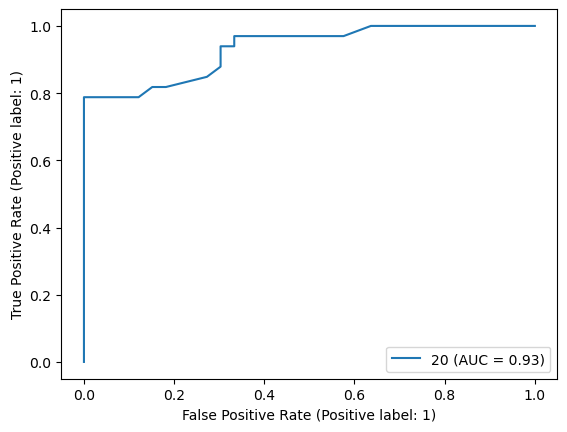

In [5]:
groups = ["qsampled", "m2"]

questions_asked = 20
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
92,0.000000,0.745098,0.000000,0.0,0.836608,0.000000,0.820717,0.000000,0.887435,0.000,...,0.000000,0.752381,0.989111,0.000000,0.642105,0.000000,0.000000,0.000000,0.000000,0.287879
47,0.000000,0.745098,1.000000,1.0,0.870695,0.000000,0.433460,0.739130,0.000000,1.000,...,0.000000,0.919753,1.000000,0.504950,0.642105,0.979247,0.000000,0.555556,0.907407,0.000000
60,1.000000,0.745098,0.931818,1.0,0.000000,1.000000,0.834601,0.697802,0.600755,1.000,...,1.000000,0.566929,1.000000,0.792079,0.000000,0.000000,0.461538,0.555556,0.907407,0.772727
56,1.000000,0.549020,0.931818,1.0,0.775595,0.500000,0.946768,0.967033,0.614507,1.000,...,1.000000,0.566929,0.405139,0.792079,0.536842,0.979167,0.000000,0.000000,0.000000,0.878788
39,0.500000,0.745098,0.931818,1.0,0.263573,0.763889,0.431034,0.991364,0.000000,1.000,...,0.285714,0.981481,0.975006,0.000000,0.642105,0.000000,1.000000,1.000000,1.000000,0.772727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.200717,0.000000,0.000000,0.0,0.829247,0.541667,0.433460,0.000000,0.874197,0.875,...,0.000000,1.000000,0.405231,0.504950,0.642105,0.770833,0.000000,0.000000,0.000000,0.772727
31,0.526570,0.549020,0.000000,0.0,0.000000,0.000000,0.000000,0.695652,0.000000,1.000,...,0.000000,0.981481,0.000000,0.792079,0.000000,0.446927,0.000000,0.000000,0.907407,0.000000
36,1.000000,0.549020,0.931818,1.0,0.870695,0.000000,0.537849,0.000000,0.000000,1.000,...,0.000000,0.919753,0.000000,0.504950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27,0.962963,0.549020,0.931818,1.0,0.000000,0.947897,0.000000,0.697802,0.000000,1.000,...,0.000000,1.000000,0.037819,0.792079,0.642105,0.770875,0.000000,1.000000,1.000000,0.424242


In [6]:
actual_data = _diss_dataset(diss[0], questions_asked, groups=["actual"])

In [7]:
pred = pd.Series(classifier.predict(actual_data.drop(["y"], axis="columns"))).replace(
    {0: "baseline", 1: "malinger"}
)

pred_prob = pd.Series(
    classifier.predict_proba(actual_data.drop(["y"], axis="columns"))[:, 1],
    name="prob_m2",
)

m2_prob = (
    pd.concat([actual_data.drop(["y"], axis="columns"), pred_prob], axis="columns")
    .set_index(pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"])
    .reset_index()
    .sort_values(by="prob_m2", ascending=False)
)

In [19]:
i = 0
alpha = 0.1

suspects = pd.read_csv(
    f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
    index_col=0,
)
display(suspects)

display(m2_prob.iloc[suspects.index, :])

print("mean m2 prob: ", m2_prob["prob_m2"].mean())
print("mean m2 prob (suspects): ", m2_prob.iloc[suspects.index, -1].mean())

,mean_dissonance
60,0.429343
63,0.401782
98,0.414350
159,0.384644
188,0.393705
210,0.414758
221,0.394433
222,0.381975
252,0.388083
261,0.462381


,record_id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,prob_m2
68,CAT1069,0.000000,0.000000,0.082353,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.842450,0.87
150,CAT1151,0.864293,0.000000,0.082353,0.0,0.000000,0.000000,0.000000,0.428571,0.000000,...,0.666667,0.000000,1.000000,0.000000,0.000000,0.446809,0.618557,0.000000,0.000000,0.87
51,CAT1052,0.000000,0.391356,0.000000,1.0,0.500000,0.867365,0.588785,1.000000,0.000000,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.74
85,CAT1086,1.000000,0.212657,0.082353,1.0,0.647059,0.000000,0.112150,0.991697,0.025974,...,0.655914,0.963068,0.000000,0.862069,0.915254,0.776596,0.618557,1.000000,0.000000,0.44
56,CAT1057,0.000000,0.000000,0.000000,0.0,0.000000,0.867365,0.112150,0.991697,0.311688,...,0.000000,0.974893,0.000000,0.954023,1.000000,0.978723,0.618557,0.829545,0.859637,0.26
120,CAT1121,0.522124,0.000000,0.082353,0.0,0.647059,0.871255,0.112150,0.250000,0.025974,...,0.655914,0.941761,0.000000,0.862069,1.000000,0.000000,0.618557,1.000000,0.859637,0.17
100,CAT1101,1.000000,0.461411,0.082353,1.0,0.647059,0.379733,0.570093,0.000000,0.025974,...,1.000000,0.000000,0.000000,0.862069,1.000000,0.446809,0.938144,1.000000,0.333333,0.14
269,CAT1270,0.000000,0.175654,0.411765,1.0,0.647059,0.379080,0.570093,0.991697,0.311688,...,0.000000,0.736842,0.571429,0.862069,1.000000,0.446809,0.618557,1.000000,0.337017,0.14
290,CAT1291,0.000000,0.000000,0.235294,1.0,0.647059,0.482095,0.570093,0.958485,0.324675,...,0.000000,0.974893,0.000000,0.954023,1.000000,0.446809,0.938144,0.829545,0.337017,0.11
57,CAT1058,0.333333,0.716216,0.694118,1.0,1.000000,0.604255,0.112150,0.750000,0.025974,...,0.989247,1.000000,1.000000,0.954023,0.244444,0.978723,0.938144,1.000000,0.933333,0.10


mean m2 prob:  0.4868092105263158
mean m2 prob (suspects):  0.3563636363636364
